In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
df = pd.read_csv('../data/CellCycle4X.csv')

<Axes: >

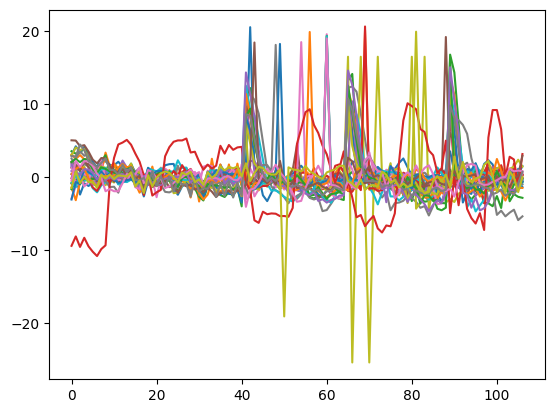

In [36]:
df[df.columns[df.max() > 10]].plot(legend=False)

<Axes: >

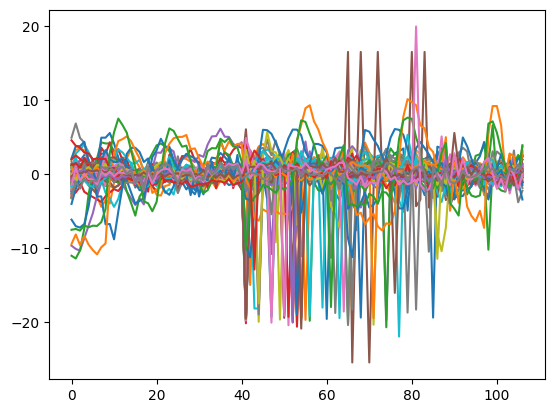

In [38]:
df[df.columns[df.min() < -10]].plot(legend=False)

<Axes: >

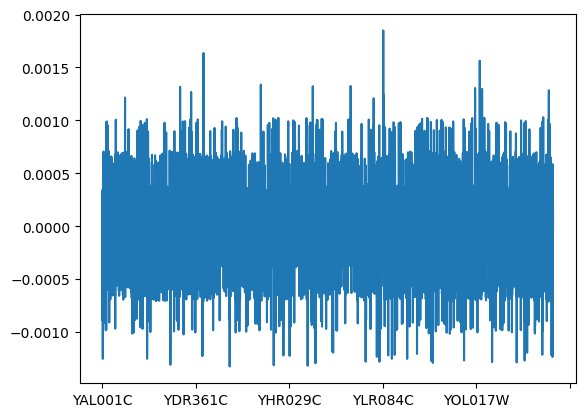

In [47]:
df.mean().plot()

<Axes: >

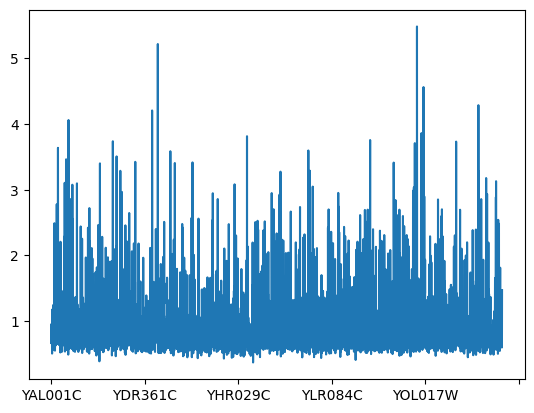

In [43]:
df.std().plot()